In [1]:
from platform import python_version
python_version()

'3.10.4'

In [2]:
pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [3]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [4]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError, MeanSquaredError, RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

import data_transformer as dataTransformer
from Utils_Python.database_connector.DatabaseConnector import DatabaseConnector
from Utils_Python.file_writer.FileWriter import FileWriter
from Utils_Python.file_reader.FileReader import FileReader

In [5]:
POINT_IN_A_DAY = 96
ADJUSTER = 2.103
ROW_COUNT = (POINT_IN_A_DAY * 5 * 2) * ADJUSTER  # (Points in 1 day * Number of Days * Number of Weeks) * n
DATABASE_NAME = 'IG_TRADING'
SCHEMA_NAME = 'FOREX_MINI'
TABLE_NAME = 'GBPUSD_15MIN'
DATA_PATH = '/ScalpFX/src/data'
MODEL_PATH = '/ScalpFX/src/model'


RANDOM_SEED = 42

In [6]:
TMP_DATA_PATH = '/ScalpFX/src/data/tmp_df.pkl'
TMP_DF_PATH = '/ScalpFX/src/data/tmp_df.pkl'
TMP_TRANS_PATH = '/ScalpFX/src/data/tmp_trans.pkl'
TMP_NORM_PATH = '/ScalpFX/src/data/tmp_norm.pkl'
TMP_PREP_PATH = '/ScalpFX/src/data/tmp_prep.json'

In [7]:
def closeDatabaseConnection(databaseConnector, cur, connObject):
    cur.close()
    databaseConnector.closeConnection(connObject)

In [8]:
# def getTrainingData(filePathToWrite, connTag, verbose=False):
filePathToWrite = TMP_DATA_PATH
connTag = "PostgresqlIgTrading"
verbose = False

databaseConnector = DatabaseConnector()
connObject = databaseConnector.openConnection(connTag)
conn = connObject['connection']
cur = conn.cursor()

query = (   
            f"SELECT * "
            f"FROM \"{DATABASE_NAME}\".\"{SCHEMA_NAME}\".\"{TABLE_NAME}\" "
            f"ORDER BY datetime DESC "
            f"LIMIT {ROW_COUNT}"
        )

colNames = None
try:
    cur.execute(query)
    colNames = [desc[0] for desc in cur.description]
except Exception as e:
    closeDatabaseConnection(databaseConnector, cur, connObject)
    raise Exception(f"Could not execute: {query}\n{e}")

res = cur.fetchall()    
closeDatabaseConnection(databaseConnector, cur, connObject)

df = pd.DataFrame(res, columns=colNames)
df = df.sort_values(['datetime'], ascending=True).reset_index()

if verbose:
    print('getTrainingData()')
    print(f"{df}\n")

df.to_pickle(filePathToWrite)
print(f"Training Data has been saved to '{filePathToWrite}'\n")


df

Successfully connect to 'PostgresqlIgTrading' database, with connection ID 'PostgresqlIgTrading_XV1R7v7E'!
Successfully close the 'PostgresqlIgTrading_XV1R7v7E' connection!
Training Data has been saved to '/ScalpFX/src/data/tmp_df.pkl'



,index,datetime,open,high,low,close,volume,inserted_on_myt
0,2018,2022-06-03 08:00:00,1.25784,1.25786,1.25711,1.25740,1430,NaT
1,2017,2022-06-03 08:15:00,1.25740,1.25819,1.25720,1.25819,1270,NaT
2,2016,2022-06-03 08:30:00,1.25820,1.25901,1.25785,1.25838,1962,NaT
3,2015,2022-06-03 08:45:00,1.25837,1.25839,1.25766,1.25787,1742,NaT
4,2014,2022-06-03 09:00:00,1.25788,1.25837,1.25759,1.25787,1446,NaT
...,...,...,...,...,...,...,...,...
2014,4,2022-07-02 03:45:00,1.20986,1.20999,1.20911,1.20965,1516,2022-07-02 11:08:58
2015,3,2022-07-02 04:00:00,1.20966,1.20994,1.20952,1.20981,833,2022-07-02 11:08:58
2016,2,2022-07-02 04:15:00,1.20983,1.21002,1.20970,1.20988,485,2022-07-02 11:08:58
2017,1,2022-07-02 04:30:00,1.20986,1.21015,1.20950,1.20961,433,2022-07-02 11:08:58


In [9]:
# def removeColumns(filePathToRead, filePathToWrite, columnNames, verbose=False):
filePathToRead = TMP_DF_PATH
filePathToWrite = TMP_DF_PATH
columnNames = ['index', 'datetime', 'inserted_on_myt']
verbose = False

df = pd.read_pickle(filePathToRead)

df.index = pd.to_datetime(df['datetime'], format='%Y-%m-%d %H:%M:%S')
working_df = df.drop(columns=columnNames)

if verbose:
    print('removeColumns()')
    print(f"{working_df}\n")

working_df.to_pickle(filePathToWrite)
print(f"Removed Columns' Training Data has been saved to '{filePathToWrite}'\n")


working_df

Removed Columns' Training Data has been saved to '/ScalpFX/src/data/tmp_df.pkl'



,open,high,low,close,volume
datetime,,,,,
2022-06-03 08:00:00,1.25784,1.25786,1.25711,1.25740,1430
2022-06-03 08:15:00,1.25740,1.25819,1.25720,1.25819,1270
2022-06-03 08:30:00,1.25820,1.25901,1.25785,1.25838,1962
2022-06-03 08:45:00,1.25837,1.25839,1.25766,1.25787,1742
2022-06-03 09:00:00,1.25788,1.25837,1.25759,1.25787,1446
...,...,...,...,...,...
2022-07-02 03:45:00,1.20986,1.20999,1.20911,1.20965,1516
2022-07-02 04:00:00,1.20966,1.20994,1.20952,1.20981,833
2022-07-02 04:15:00,1.20983,1.21002,1.20970,1.20988,485


In [10]:
# def transformData(filePathToRead, filePathToWrite, verbose=False):
filePathToRead = TMP_DF_PATH
filePathToWrite = TMP_TRANS_PATH
verbose = False

df = pd.read_pickle(filePathToRead)

working_df = dataTransformer.calcFeaturesEngineering(df, verbose=verbose)
working_df = dataTransformer.calcTA(working_df, verbose=verbose)

working_df.to_pickle(filePathToWrite)
print(f"Transformed Data has been saved to '{filePathToWrite}'\n")

working_df

C:\Users\zaimp\anaconda3\envs\ScalpFX\lib\site-packages\ta\trend.py:769: RuntimeWarning: invalid value encountered in double_scalars
  dip[idx] = 100 * (self._dip[idx] / value)
C:\Users\zaimp\anaconda3\envs\ScalpFX\lib\site-packages\ta\trend.py:774: RuntimeWarning: invalid value encountered in double_scalars
  din[idx] = 100 * (self._din[idx] / value)


Transformed Data has been saved to '/ScalpFX/src/data/tmp_trans.pkl'



,open,high,low,close,volume,O-H,O-L,C-H,C-L,H-L,...,Trend_MI,Trend_SMA_12,Trend_SMA_50,Trend_SMA_100,Trend_STC,Trend_TRIX,Trend_VI_vortex_indicator_diff,Trend_VI_vortex_indicator_neg,Trend_VI_vortex_indicator_pos,Trend_WMA
datetime,,,,,,,,,,,,,,,,,,,,,
2022-06-06 07:45:00,1.24985,1.25028,1.24893,1.24899,1364,0.00043,0.00092,0.00129,0.00006,0.00135,...,22.912649,1.249302,1.250675,1.253964,50.000000,-0.003354,0.022196,0.931075,0.953271,1.249384
2022-06-06 08:00:00,1.24905,1.24969,1.24874,1.24969,1972,0.00064,0.00031,0.00000,0.00095,0.00095,...,23.357141,1.249354,1.250624,1.253887,50.000007,-0.002886,0.018391,0.982759,1.001149,1.249444
2022-06-06 08:15:00,1.24973,1.25009,1.24927,1.24937,1377,0.00036,0.00046,0.00072,0.00010,0.00082,...,23.778329,1.249367,1.250541,1.253799,62.500014,-0.002506,0.114790,0.922737,1.037528,1.249447
2022-06-06 08:30:00,1.24938,1.24943,1.24877,1.24911,1141,0.00005,0.00061,0.00032,0.00034,0.00066,...,24.129536,1.249366,1.250430,1.253707,57.143038,-0.002271,0.002165,0.989177,0.991342,1.249407
2022-06-06 08:45:00,1.24912,1.24917,1.24810,1.24825,1940,0.00005,0.00102,0.00092,0.00015,0.00107,...,24.530347,1.249289,1.250291,1.253610,28.571519,-0.002380,-0.103870,1.022403,0.918534,1.249235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-07-02 03:45:00,1.20986,1.20999,1.20911,1.20965,1516,0.00013,0.00075,0.00034,0.00054,0.00088,...,25.400835,1.207847,1.205526,1.210203,99.999985,0.022371,0.628788,0.699036,1.327824,1.208893
2022-07-02 04:00:00,1.20966,1.20994,1.20952,1.20981,833,0.00028,0.00014,0.00013,0.00029,0.00042,...,25.235489,1.208307,1.205503,1.210127,99.999993,0.023381,0.755822,0.634439,1.390261,1.209195
2022-07-02 04:15:00,1.20983,1.21002,1.20970,1.20988,485,0.00019,0.00013,0.00014,0.00018,0.00032,...,25.008583,1.208775,1.205481,1.210052,99.999996,0.024004,0.835667,0.604274,1.439941,1.209437


In [11]:
# def normalisedDataframe(filePathToRead, filePathToWrite, verbose=False):
filePathToRead = TMP_TRANS_PATH
filePathToWrite = TMP_NORM_PATH
verbose = False

df = pd.read_pickle(filePathToRead)

working_df = dataTransformer.normalised(df, mode='train')

if verbose:
    print('normalisedDataframe()')
    print(f"{working_df}\n")

working_df.to_pickle(filePathToWrite)
print(f"Normalised Data has been saved to '{filePathToWrite}'\n")

working_df

Normalised Data has been saved to '/ScalpFX/src/data/tmp_norm.pkl'



,open,high,low,close,volume,O-H,O-L,C-H,C-L,H-L,...,Trend_MI,Trend_SMA_12,Trend_SMA_50,Trend_SMA_100,Trend_STC,Trend_TRIX,Trend_VI_vortex_indicator_diff,Trend_VI_vortex_indicator_neg,Trend_VI_vortex_indicator_pos,Trend_WMA
datetime,,,,,,,,,,,,,,,,,,,,,
2022-06-06 07:45:00,0.842797,0.845468,0.838515,0.829295,0.178965,0.042957,0.080702,0.107950,0.005314,0.109935,...,0.207382,0.837273,0.863177,0.945837,0.500000,0.361233,0.455607,0.448001,0.420153,0.838541
2022-06-06 08:00:00,0.830283,0.836068,0.835647,0.840238,0.258797,0.063936,0.027193,0.000000,0.084145,0.077362,...,0.240821,0.838131,0.862299,0.944408,0.500000,0.365186,0.453635,0.500643,0.465159,0.839514
2022-06-06 08:15:00,0.840920,0.842441,0.843646,0.835235,0.180672,0.035964,0.040351,0.060251,0.008857,0.066775,...,0.272507,0.838349,0.860872,0.942773,0.625000,0.368397,0.503611,0.439509,0.499354,0.839554
2022-06-06 08:30:00,0.835445,0.831926,0.836100,0.831171,0.149685,0.004995,0.053509,0.026778,0.030115,0.053746,...,0.298928,0.838322,0.858975,0.941054,0.571430,0.370390,0.445222,0.507181,0.455940,0.838908
2022-06-06 08:45:00,0.831378,0.827784,0.825989,0.817727,0.254596,0.004995,0.089474,0.076987,0.013286,0.087134,...,0.329081,0.837069,0.856584,0.939271,0.285715,0.369470,0.390251,0.541023,0.387500,0.836112
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-07-02 03:45:00,0.217269,0.203600,0.237549,0.214319,0.198923,0.012987,0.065789,0.028452,0.047830,0.071661,...,0.394567,0.159525,0.088791,0.134549,1.000000,0.578666,0.770084,0.211660,0.772233,0.178862
2022-07-02 04:00:00,0.214140,0.202804,0.243737,0.216820,0.109244,0.027972,0.012281,0.010879,0.025686,0.034202,...,0.382128,0.167046,0.088400,0.133136,1.000000,0.587202,0.835943,0.145866,0.830924,0.183783
2022-07-02 04:15:00,0.216800,0.204078,0.246453,0.217915,0.063550,0.018981,0.011404,0.011715,0.015943,0.026059,...,0.365058,0.174703,0.088016,0.131753,1.000000,0.592475,0.877337,0.115142,0.877624,0.187727


In [12]:
filePathToRead = TMP_NORM_PATH

df = pd.read_pickle(filePathToRead)

column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

In [13]:
train_df

,open,high,low,close,volume,O-H,O-L,C-H,C-L,H-L,...,Trend_MI,Trend_SMA_12,Trend_SMA_50,Trend_SMA_100,Trend_STC,Trend_TRIX,Trend_VI_vortex_indicator_diff,Trend_VI_vortex_indicator_neg,Trend_VI_vortex_indicator_pos,Trend_WMA
datetime,,,,,,,,,,,,,,,,,,,,,
2022-06-06 07:45:00,0.842797,0.845468,0.838515,0.829295,0.178965,0.042957,0.080702,0.107950,0.005314,0.109935,...,0.207382,0.837273,0.863177,0.945837,0.500000,0.361233,0.455607,0.448001,0.420153,0.838541
2022-06-06 08:00:00,0.830283,0.836068,0.835647,0.840238,0.258797,0.063936,0.027193,0.000000,0.084145,0.077362,...,0.240821,0.838131,0.862299,0.944408,0.500000,0.365186,0.453635,0.500643,0.465159,0.839514
2022-06-06 08:15:00,0.840920,0.842441,0.843646,0.835235,0.180672,0.035964,0.040351,0.060251,0.008857,0.066775,...,0.272507,0.838349,0.860872,0.942773,0.625000,0.368397,0.503611,0.439509,0.499354,0.839554
2022-06-06 08:30:00,0.835445,0.831926,0.836100,0.831171,0.149685,0.004995,0.053509,0.026778,0.030115,0.053746,...,0.298928,0.838322,0.858975,0.941054,0.571430,0.370390,0.445222,0.507181,0.455940,0.838908
2022-06-06 08:45:00,0.831378,0.827784,0.825989,0.817727,0.254596,0.004995,0.089474,0.076987,0.013286,0.087134,...,0.329081,0.837069,0.856584,0.939271,0.285715,0.369470,0.390251,0.541023,0.387500,0.836112
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-24 04:30:00,0.472392,0.462163,0.490039,0.471158,0.067752,0.004995,0.028947,0.011715,0.021258,0.030945,...,0.287780,0.443439,0.399187,0.395009,0.997378,0.443223,0.747539,0.247395,0.764333,0.455977
2022-06-24 04:45:00,0.470358,0.465350,0.489436,0.472409,0.094800,0.037962,0.021053,0.021757,0.031887,0.050489,...,0.251288,0.448685,0.402288,0.394957,0.998689,0.449095,0.772754,0.220119,0.784880,0.458352
2022-06-24 05:00:00,0.470984,0.460411,0.486568,0.466938,0.199842,0.002997,0.041228,0.025105,0.017715,0.040717,...,0.216016,0.452404,0.404405,0.394857,0.982487,0.452324,0.772976,0.216000,0.781482,0.459046


In [14]:
val_df

,open,high,low,close,volume,O-H,O-L,C-H,C-L,H-L,...,Trend_MI,Trend_SMA_12,Trend_SMA_50,Trend_SMA_100,Trend_STC,Trend_TRIX,Trend_VI_vortex_indicator_diff,Trend_VI_vortex_indicator_neg,Trend_VI_vortex_indicator_pos,Trend_WMA
datetime,,,,,,,,,,,,,,,,,,,,,
2022-06-24 05:45:00,0.471610,0.460889,0.488379,0.467719,0.058167,0.001998,0.034211,0.023431,0.011515,0.033388,...,0.133072,0.458930,0.409691,0.394551,0.214777,0.452131,0.565068,0.410288,0.583817,0.458354
2022-06-24 06:00:00,0.468638,0.462641,0.487172,0.469126,0.288209,0.031968,0.024561,0.025105,0.026572,0.048860,...,0.114399,0.458766,0.411536,0.394457,0.107389,0.450392,0.475815,0.504217,0.508673,0.457828
2022-06-24 06:15:00,0.468950,0.460730,0.489436,0.467719,0.267332,0.017982,0.013158,0.022594,0.005314,0.026873,...,0.091945,0.458113,0.413591,0.394342,0.053694,0.447913,0.393820,0.584950,0.434511,0.457101
2022-06-24 06:30:00,0.467699,0.467261,0.486568,0.475692,0.345194,0.066933,0.022807,0.014226,0.067316,0.075733,...,0.076437,0.457445,0.415574,0.394346,0.026847,0.446213,0.362699,0.581126,0.374555,0.457753
2022-06-24 06:45:00,0.475364,0.470607,0.495472,0.480225,0.209034,0.038961,0.014035,0.007531,0.040744,0.044788,...,0.066026,0.457540,0.417649,0.394370,0.043818,0.445614,0.400009,0.586666,0.447316,0.459234
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-30 03:45:00,0.252464,0.239605,0.272110,0.246834,0.066964,0.013986,0.062281,0.043515,0.029229,0.069218,...,0.234965,0.237674,0.246543,0.260800,0.029673,0.328674,0.345296,0.625539,0.383989,0.235065
2022-06-30 04:00:00,0.245894,0.236259,0.272714,0.248710,0.051996,0.034965,0.021930,0.015900,0.036315,0.048860,...,0.200863,0.235875,0.244094,0.259600,0.014836,0.327743,0.306661,0.702823,0.385262,0.233119
2022-06-30 04:15:00,0.248710,0.243428,0.279203,0.255589,0.031644,0.061938,0.000000,0.016736,0.037201,0.050489,...,0.173093,0.234295,0.241576,0.258431,0.103721,0.328315,0.325804,0.637584,0.359764,0.232550


In [15]:
test_df

,open,high,low,close,volume,O-H,O-L,C-H,C-L,H-L,...,Trend_MI,Trend_SMA_12,Trend_SMA_50,Trend_SMA_100,Trend_STC,Trend_TRIX,Trend_VI_vortex_indicator_diff,Trend_VI_vortex_indicator_neg,Trend_VI_vortex_indicator_pos,Trend_WMA
datetime,,,,,,,,,,,,,,,,,,,,,
2022-06-30 05:00:00,0.261223,0.273220,0.282071,0.254963,0.030593,0.168831,0.053509,0.176569,0.016829,0.187296,...,0.122105,0.231079,0.235374,0.254893,0.789882,0.336070,0.422593,0.454824,0.366589,0.232406
2022-06-30 05:15:00,0.254184,0.240720,0.283429,0.254807,0.088498,0.009990,0.006140,0.006695,0.007972,0.013844,...,0.114127,0.229976,0.233587,0.253744,0.894941,0.339246,0.359159,0.617181,0.401412,0.232448
2022-06-30 05:30:00,0.254497,0.240561,0.282976,0.255276,0.024028,0.006993,0.010526,0.003347,0.013286,0.015472,...,0.103783,0.229540,0.231570,0.252546,0.947470,0.342545,0.365938,0.614180,0.410934,0.232734
2022-06-30 05:45:00,0.254497,0.240083,0.283127,0.254651,0.019958,0.003996,0.009649,0.004184,0.008857,0.012215,...,0.090483,0.230071,0.229693,0.251412,0.973735,0.345779,0.428452,0.589048,0.501086,0.232987
2022-06-30 06:00:00,0.254341,0.240083,0.280561,0.253869,0.033351,0.004995,0.023684,0.008368,0.019486,0.026059,...,0.076757,0.230316,0.227628,0.250281,0.986868,0.348799,0.495657,0.491475,0.532891,0.233033
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-07-02 03:45:00,0.217269,0.203600,0.237549,0.214319,0.198923,0.012987,0.065789,0.028452,0.047830,0.071661,...,0.394567,0.159525,0.088791,0.134549,1.000000,0.578666,0.770084,0.211660,0.772233,0.178862
2022-07-02 04:00:00,0.214140,0.202804,0.243737,0.216820,0.109244,0.027972,0.012281,0.010879,0.025686,0.034202,...,0.382128,0.167046,0.088400,0.133136,1.000000,0.587202,0.835943,0.145866,0.830924,0.183783
2022-07-02 04:15:00,0.216800,0.204078,0.246453,0.217915,0.063550,0.018981,0.011404,0.011715,0.015943,0.026059,...,0.365058,0.174703,0.088016,0.131753,1.000000,0.592475,0.877337,0.115142,0.877624,0.187727


In [16]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [17]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [18]:
def plot(self, model=None, plot_col='close', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time')

WindowGenerator.plot = plot

In [19]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [20]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [21]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

In [22]:
MAX_EPOCHS = 1000000

In [23]:
def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

In [24]:
val_performance = {}
performance = {}

In [25]:
CONV_WIDTH = 96
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=['close'])

conv_window

Total window size: 97
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95]
Label indices: [96]
Label column name(s): ['close']

Text(0.5, 1.0, 'Given 96 points of inputs, predict 1 point into the future.')

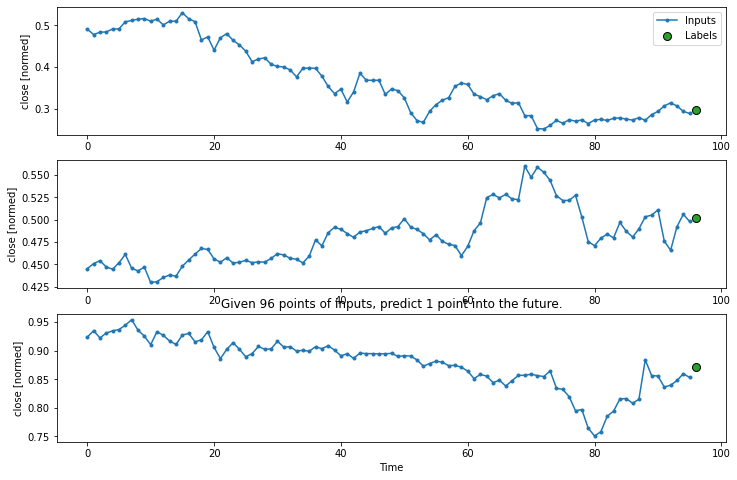

In [26]:
conv_window.plot()
plt.title("Given 96 points of inputs, predict 1 point into the future.")

In [27]:
multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])

In [28]:
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', multi_step_dense(conv_window.example[0]).shape)

Input shape: (32, 96, 86)
Output shape: (32, 1, 1)


In [29]:
history = compile_and_fit(multi_step_dense, conv_window)

IPython.display.clear_output()
val_performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.val)
performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.test, verbose=0)

9/9 [==============================] - 0s 2ms/step - loss: 6.9851e-04 - mean_absolute_error: 0.0207


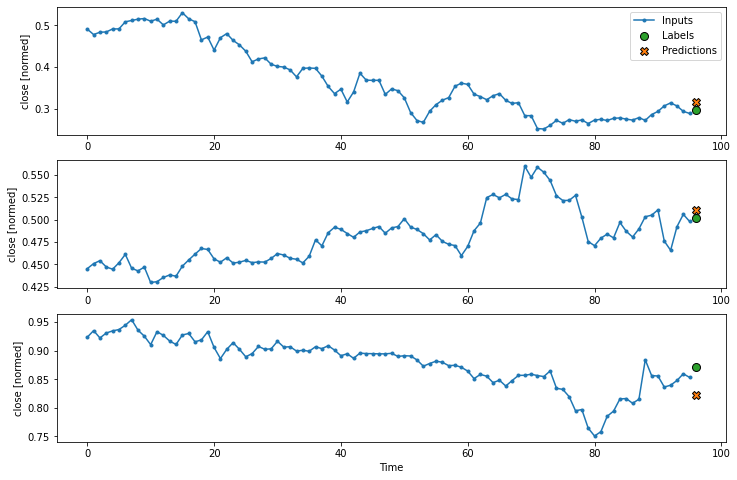

In [30]:
conv_window.plot(multi_step_dense)

In [31]:
wide_window = WindowGenerator(
    input_width=96, label_width=96, shift=1,
    label_columns=['close'])

wide_window

Total window size: 97
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96]
Label column name(s): ['close']

In [32]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(512, return_sequences=True),
    tf.keras.layers.LSTM(256, return_sequences=True),
    tf.keras.layers.LSTM(64, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=8, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

In [33]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', lstm_model(wide_window.example[0]).shape)

Input shape: (32, 96, 86)
Output shape: (32, 96, 1)


In [34]:
history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

9/9 [==============================] - 0s 14ms/step - loss: 2.0853e-04 - mean_absolute_error: 0.0109


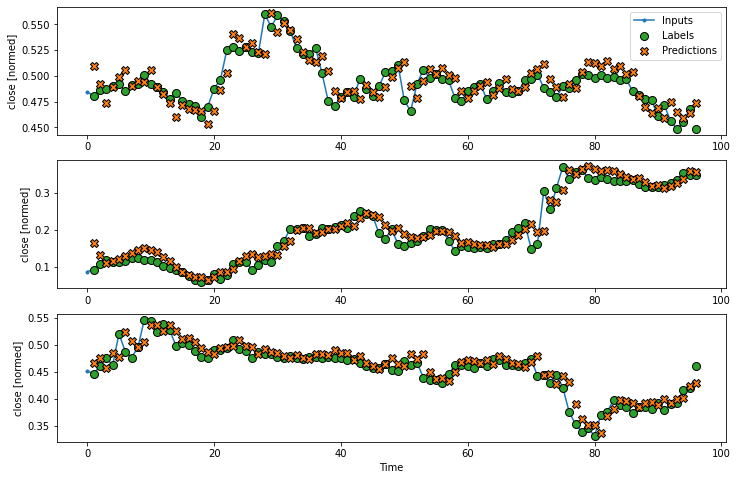

In [35]:
wide_window.plot(lstm_model)

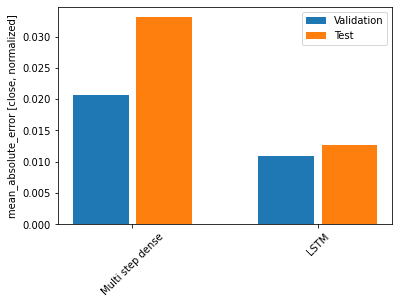

In [36]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [close, normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()

In [37]:
for name, value in performance.items():
  print(f'{name:12s}: {value[1]:0.4f}')

Multi step dense: 0.0331
LSTM        : 0.0126


In [43]:
wide_window.train_df

,open,high,low,close,volume,O-H,O-L,C-H,C-L,H-L,...,Trend_MI,Trend_SMA_12,Trend_SMA_50,Trend_SMA_100,Trend_STC,Trend_TRIX,Trend_VI_vortex_indicator_diff,Trend_VI_vortex_indicator_neg,Trend_VI_vortex_indicator_pos,Trend_WMA
datetime,,,,,,,,,,,,,,,,,,,,,
2022-06-06 07:45:00,0.842797,0.845468,0.838515,0.829295,0.178965,0.042957,0.080702,0.107950,0.005314,0.109935,...,0.207382,0.837273,0.863177,0.945837,0.500000,0.361233,0.455607,0.448001,0.420153,0.838541
2022-06-06 08:00:00,0.830283,0.836068,0.835647,0.840238,0.258797,0.063936,0.027193,0.000000,0.084145,0.077362,...,0.240821,0.838131,0.862299,0.944408,0.500000,0.365186,0.453635,0.500643,0.465159,0.839514
2022-06-06 08:15:00,0.840920,0.842441,0.843646,0.835235,0.180672,0.035964,0.040351,0.060251,0.008857,0.066775,...,0.272507,0.838349,0.860872,0.942773,0.625000,0.368397,0.503611,0.439509,0.499354,0.839554
2022-06-06 08:30:00,0.835445,0.831926,0.836100,0.831171,0.149685,0.004995,0.053509,0.026778,0.030115,0.053746,...,0.298928,0.838322,0.858975,0.941054,0.571430,0.370390,0.445222,0.507181,0.455940,0.838908
2022-06-06 08:45:00,0.831378,0.827784,0.825989,0.817727,0.254596,0.004995,0.089474,0.076987,0.013286,0.087134,...,0.329081,0.837069,0.856584,0.939271,0.285715,0.369470,0.390251,0.541023,0.387500,0.836112
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-24 04:30:00,0.472392,0.462163,0.490039,0.471158,0.067752,0.004995,0.028947,0.011715,0.021258,0.030945,...,0.287780,0.443439,0.399187,0.395009,0.997378,0.443223,0.747539,0.247395,0.764333,0.455977
2022-06-24 04:45:00,0.470358,0.465350,0.489436,0.472409,0.094800,0.037962,0.021053,0.021757,0.031887,0.050489,...,0.251288,0.448685,0.402288,0.394957,0.998689,0.449095,0.772754,0.220119,0.784880,0.458352
2022-06-24 05:00:00,0.470984,0.460411,0.486568,0.466938,0.199842,0.002997,0.041228,0.025105,0.017715,0.040717,...,0.216016,0.452404,0.404405,0.394857,0.982487,0.452324,0.772976,0.216000,0.781482,0.459046


In [44]:
wide_window.test_df

,open,high,low,close,volume,O-H,O-L,C-H,C-L,H-L,...,Trend_MI,Trend_SMA_12,Trend_SMA_50,Trend_SMA_100,Trend_STC,Trend_TRIX,Trend_VI_vortex_indicator_diff,Trend_VI_vortex_indicator_neg,Trend_VI_vortex_indicator_pos,Trend_WMA
datetime,,,,,,,,,,,,,,,,,,,,,
2022-06-30 05:00:00,0.261223,0.273220,0.282071,0.254963,0.030593,0.168831,0.053509,0.176569,0.016829,0.187296,...,0.122105,0.231079,0.235374,0.254893,0.789882,0.336070,0.422593,0.454824,0.366589,0.232406
2022-06-30 05:15:00,0.254184,0.240720,0.283429,0.254807,0.088498,0.009990,0.006140,0.006695,0.007972,0.013844,...,0.114127,0.229976,0.233587,0.253744,0.894941,0.339246,0.359159,0.617181,0.401412,0.232448
2022-06-30 05:30:00,0.254497,0.240561,0.282976,0.255276,0.024028,0.006993,0.010526,0.003347,0.013286,0.015472,...,0.103783,0.229540,0.231570,0.252546,0.947470,0.342545,0.365938,0.614180,0.410934,0.232734
2022-06-30 05:45:00,0.254497,0.240083,0.283127,0.254651,0.019958,0.003996,0.009649,0.004184,0.008857,0.012215,...,0.090483,0.230071,0.229693,0.251412,0.973735,0.345779,0.428452,0.589048,0.501086,0.232987
2022-06-30 06:00:00,0.254341,0.240083,0.280561,0.253869,0.033351,0.004995,0.023684,0.008368,0.019486,0.026059,...,0.076757,0.230316,0.227628,0.250281,0.986868,0.348799,0.495657,0.491475,0.532891,0.233033
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-07-02 03:45:00,0.217269,0.203600,0.237549,0.214319,0.198923,0.012987,0.065789,0.028452,0.047830,0.071661,...,0.394567,0.159525,0.088791,0.134549,1.000000,0.578666,0.770084,0.211660,0.772233,0.178862
2022-07-02 04:00:00,0.214140,0.202804,0.243737,0.216820,0.109244,0.027972,0.012281,0.010879,0.025686,0.034202,...,0.382128,0.167046,0.088400,0.133136,1.000000,0.587202,0.835943,0.145866,0.830924,0.183783
2022-07-02 04:15:00,0.216800,0.204078,0.246453,0.217915,0.063550,0.018981,0.011404,0.011715,0.015943,0.026059,...,0.365058,0.174703,0.088016,0.131753,1.000000,0.592475,0.877337,0.115142,0.877624,0.187727
